In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For time series models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# For non-time series models
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For saving models
import pickle


In [2]:
# Load data
trans_data1 = pd.read_csv("/content/Transactional_data_retail_01.csv")
trans_data2 = pd.read_csv("/content/Transactional_data_retail_02.csv")
product_info = pd.read_csv("/content/ProductInfo.csv")
customer_demo = pd.read_csv("/content/CustomerDemographics.csv")


In [3]:
trans_data1.head()

,Invoice,StockCode,Quantity,Price,Customer ID,InvoiceDate
0,489434,85048,12,6.95,13085.0,01 December 2021
1,489434,79323P,12,6.75,13085.0,01 December 2021
2,489434,79323W,12,6.75,13085.0,01 December 2021
3,489434,22041,48,2.10,13085.0,01 December 2021
4,489434,21232,24,1.25,13085.0,01 December 2021


In [4]:
trans_data2.head()


,Invoice,StockCode,Quantity,Price,Customer ID,InvoiceDate
0,536365,85123A,6,2.55,17850.0,01-12-2022
1,536365,71053,6,3.39,17850.0,01-12-2022
2,536365,84406B,8,2.75,17850.0,01-12-2022
3,536365,84029G,6,3.39,17850.0,01-12-2022
4,536365,84029E,6,3.39,17850.0,01-12-2022


In [5]:
trans_data1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Quantity     525461 non-null  int64  
 3   Price        525461 non-null  float64
 4   Customer ID  417534 non-null  float64
 5   InvoiceDate  525461 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 24.1+ MB


In [6]:
trans_data2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Quantity     541910 non-null  int64  
 3   Price        541910 non-null  float64
 4   Customer ID  406830 non-null  float64
 5   InvoiceDate  541910 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 24.8+ MB


In [7]:
trans_data1.isnull().sum()

,0
Invoice,0
StockCode,0
Quantity,0
Price,0
Customer ID,107927
InvoiceDate,0


In [8]:
trans_data2.isnull().sum()

,0
Invoice,0
StockCode,0
Quantity,0
Price,0
Customer ID,135080
InvoiceDate,0


In [9]:
trans_data1.describe()

,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


In [10]:
product_info.head(1)

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER


**Step 3: Data Preprocessing**

*1.Concatenate Transactional Data and Handle Missing Values *

In [11]:
# Concatenate transactional datasets
trans_data = pd.concat([trans_data1, trans_data2], ignore_index=True)
trans_data['Customer ID'].fillna("Unknown", inplace=True)

# Ensure 'Customer ID' is of the same type in both DataFrames
trans_data['Customer ID'] = trans_data['Customer ID'].astype(str)
customer_demo['Customer ID'] = customer_demo['Customer ID'].astype(str)

# Merge product and customer information
trans_data = trans_data.merge(product_info, on='StockCode', how='left')
trans_data = trans_data.merge(customer_demo, on='Customer ID', how='left')

# Create additional features
trans_data['Revenue'] = trans_data['Quantity'] * trans_data['Price']
# Handle parsing errors and potentially incorrect date formats
trans_data['InvoiceDate'] = pd.to_datetime(trans_data['InvoiceDate'], errors='coerce')
trans_data['Year'] = trans_data['InvoiceDate'].dt.year
trans_data['Month'] = trans_data['InvoiceDate'].dt.month
trans_data['Week'] = trans_data['InvoiceDate'].dt.isocalendar().week

<ipython-input-11-e7cf561dcf9d>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trans_data['Customer ID'].fillna("Unknown", inplace=True)
<ipython-input-11-e7cf561dcf9d>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  trans_data['Customer ID'].fillna("Unknown", inplace=True)


In [12]:
trans_data.head(1)

,Invoice,StockCode,Quantity,Price,Customer ID,InvoiceDate,Description,Country,Revenue,Year,Month,Week
0,489434,85048,12,6.95,13085.0,2021-12-01,15CM CHRISTMAS GLASS BALL 20 LIGHTS,NaN,83.4,2021.0,12.0,48


In [13]:
trans_data.to_csv('trans_data.csv')

**Step 4: Exploratory Data Analysis (EDA)**

*1. Calculate Summary Statistics*

In [14]:
# Customer-level summary
customer_summary = trans_data.groupby('Customer ID').agg({
    'Invoice': 'nunique',
    'Quantity': 'sum',
    'Revenue': 'sum'
}).reset_index()

# Item-level summary
item_summary = trans_data.groupby('StockCode').agg({
    'Quantity': 'sum',
    'Revenue': 'sum'
}).reset_index()

# Transaction-level summary
transaction_summary = trans_data.groupby('Invoice').agg({
    'Quantity': 'sum',
    'Revenue': 'sum'
}).reset_index()


*2. Identify Top 10 Products by Quantity and Revenue *

In [15]:
top_10_quantity = trans_data.groupby('StockCode')['Quantity'].sum().nlargest(10).reset_index()
top_10_revenue = trans_data.groupby('StockCode')['Revenue'].sum().nlargest(10).reset_index()


In [16]:
top_10_quantity.head(1)

,StockCode,Quantity
0,85123A,480330


In [17]:
top_10_revenue.head(1)

,StockCode,Revenue
0,22423,2622509.2


In [18]:
# Merge the top_10_quantity and top_10_revenue dataframes on 'StockCode'
top_10_combined = pd.merge(top_10_quantity, top_10_revenue, on='StockCode', suffixes=('_quantity', '_revenue'))

# Display the merged dataframe
print(top_10_combined)


  StockCode  Quantity     Revenue
0    85123A    480330  1268600.10
1    85099B    382956   725114.04
2     23084    245168   534052.72
3     84879    242115   394241.55
4     22423    206112  2622509.20
5     21181    201136   406239.36
6     20713    168669   368469.99


In [19]:
top_10_quantity.to_csv('top_10_quantity.csv')

*3. Visualization*

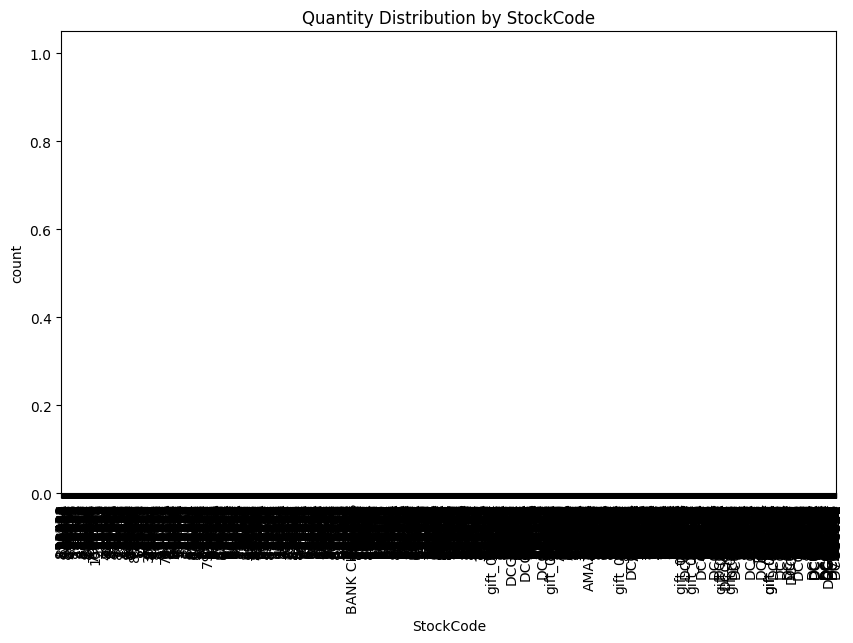

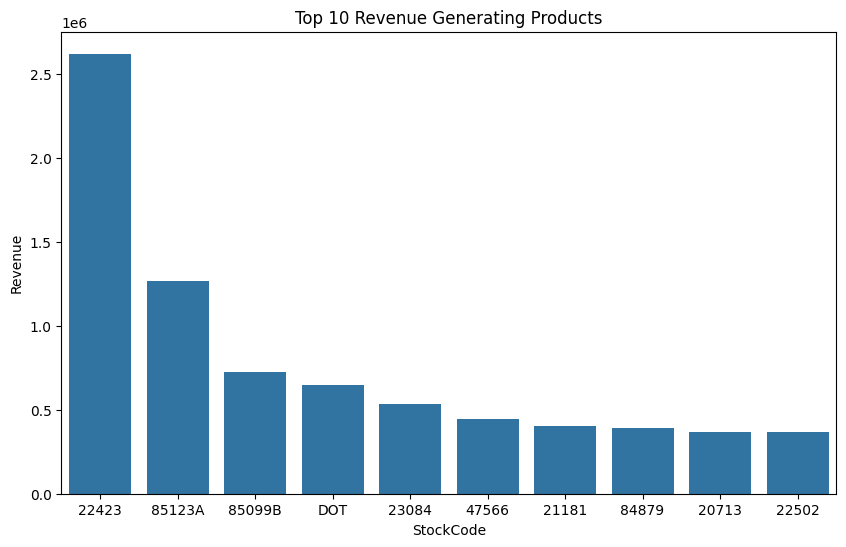

In [20]:
# Quantity distribution by StockCode
plt.figure(figsize=(10, 6))
sns.countplot(data=top_10_quantity, x='StockCode', order=trans_data['StockCode'].value_counts().index) # Changed x to 'StockCode' to match column in top_10_quantity
plt.xticks(rotation=90)
plt.title("Quantity Distribution by StockCode") # Changed title to reflect the change
plt.show()

# Revenue distribution for top 10 products
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_revenue, x='StockCode', y='Revenue')
plt.title("Top 10 Revenue Generating Products")
plt.show()

**Step 5: Prepare Data for Modeling**

In [21]:
# Filter data for a top-selling stock code
selected_stock_data = trans_data[trans_data['StockCode'] == top_10_quantity.iloc[0]['StockCode']]
selected_stock_data = selected_stock_data.set_index('InvoiceDate').resample('W')['Quantity'].sum()
train_data, test_data = train_test_split(selected_stock_data, test_size=0.3, shuffle=False)


In [22]:
selected_stock_data.to_csv('selected_stock_data.csv')

In [23]:
selected_stock_data.head(1)

,Quantity
InvoiceDate,
2021-12-05,7255


**Step 6: Time Series Modeling**

*1. ARIMA Model*

In [24]:
arima_model = ARIMA(train_data, order=(1, 1, 1))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test_data))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [25]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Fit ARIMA model
arima_model = ARIMA(train_data, order=(1, 1, 1))
arima_fit = arima_model.fit()

# Forecast for the test data period
arima_forecast = arima_fit.forecast(steps=len(test_data))

# Calculate Error and Accuracy
mse_error = mean_squared_error(test_data, arima_forecast)
mape_error = mean_absolute_percentage_error(test_data, arima_forecast) * 100  # Convert to percentage

print("Mean Squared Error (MSE):", mse_error)
print("Mean Absolute Percentage Error (MAPE):", mape_error, "%")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Mean Squared Error (MSE): 2944211.0555299846
Mean Absolute Percentage Error (MAPE): 18.692908707076228 %


*2.Exponential Smoothing (ETS) Model *

In [26]:
# Make sure you have enough data for the seasonal period
# Check the combined length of train_data and test_data
if len(train_data) + len(test_data) < 2 * 12: # Changed 52 to 12 to reflect the number of months in a year
    # Instead of raising an error, print a warning and continue with the code.
    print("Warning: Not enough data for seasonal model. Results may be unreliable.")
    # Consider using a simpler model or gathering more data.
else:
    ets_model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=12).fit()
    ets_forecast = ets_model.forecast(steps=len(test_data))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [27]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Check if data length is sufficient
if len(train_data) + len(test_data) < 2 * 12: # Changed 52 to 12 to reflect the number of months in a year
    print("Warning: Not enough data for seasonal model. Results may be unreliable.")
    print("Consider using a simpler model or gathering more data.")
else:
    # Fit Exponential Smoothing model
    ets_model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=12).fit()

    # Forecast for the test data period
    ets_forecast = ets_model.forecast(steps=len(test_data))

    # Calculate Error and Accuracy
    mse_error = mean_squared_error(test_data, ets_forecast)
    mape_error = mean_absolute_percentage_error(test_data, ets_forecast) * 100  # Convert to percentage

    print("Mean Squared Error (MSE):", mse_error)
    print("Mean Absolute Percentage Error (MAPE):", mape_error, "%")

Mean Squared Error (MSE): 3322816.0191347236
Mean Absolute Percentage Error (MAPE): 27.853499416285143 %


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


*3.Prophet Model*

In [28]:
# Make sure to install the prophet package first if you don't have it
!pip install prophet

# Import the Prophet class from the fbprophet module
from prophet import Prophet

# Prepare data for Prophet
prophet_data = selected_stock_data.reset_index().rename(columns={'InvoiceDate': 'ds', 'Quantity': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_data[:len(train_data)])
prophet_forecast = prophet_model.make_future_dataframe(periods=len(test_data), freq='W')
prophet_forecast = prophet_model.predict(prophet_forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq27s7drg/_k54urs_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq27s7drg/7oppf6tq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37123', 'data', 'file=/tmp/tmpq27s7drg/_k54urs_.json', 'init=/tmp/tmpq27s7drg/7oppf6tq.json', 'output', 'file=/tmp/tmpq27s7drg/prophet_modelbpzybfjp/prophet_model-20241005172819.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:28:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:20 - cmdstanpy - INFO - Chai

In [29]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Prepare data for Prophet
prophet_data = selected_stock_data.reset_index().rename(columns={'InvoiceDate': 'ds', 'Quantity': 'y'})

# Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data[:len(train_data)])

# Create future dataframe for predictions
prophet_forecast = prophet_model.make_future_dataframe(periods=len(test_data), freq='W')
prophet_forecast = prophet_model.predict(prophet_forecast)

# Extract the forecasted values
forecasted_values = prophet_forecast['yhat'][-len(test_data):].values  # Get the last 'len(test_data)' forecasts

# Calculate Error and Accuracy
mse_error = mean_squared_error(test_data, forecasted_values)
mape_error = mean_absolute_percentage_error(test_data, forecasted_values) * 100  # Convert to percentage

print("Mean Squared Error (MSE):", mse_error)
print("Mean Absolute Percentage Error (MAPE):", mape_error, "%")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq27s7drg/d3dxhyd1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq27s7drg/wv_bakio.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21381', 'data', 'file=/tmp/tmpq27s7drg/d3dxhyd1.json', 'init=/tmp/tmpq27s7drg/wv_bakio.json', 'output', 'file=/tmp/tmpq27s7drg/prophet_modelzzyi_25t/prophet_model-20241005172820.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:28:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:20 - cmdstanpy - INFO - Chai

Mean Squared Error (MSE): 6435607.768790991
Mean Absolute Percentage Error (MAPE): 29.222209297973013 %


*4. LSTM Model*

In [30]:
# LSTM data preparation
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 4
lstm_data = selected_stock_data.values.reshape(-1, 1)
X_lstm, y_lstm = create_sequences(lstm_data, n_steps)
X_train, X_test, y_train, y_test = X_lstm[:len(train_data)-n_steps], X_lstm[len(train_data)-n_steps:], y_lstm[:len(train_data)-n_steps], y_lstm[len(train_data)-n_steps:]

# Define and train LSTM model
lstm_model = Sequential([LSTM(50, activation='relu', input_shape=(n_steps, 1)), Dense(1)])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, validation_split=0.2)

lstm_forecast = lstm_model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 30817312.0000 - val_loss: 30005458.0000
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 30562966.0000 - val_loss: 29782658.0000
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 30350644.0000 - val_loss: 29626304.0000
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 30196330.0000 - val_loss: 29479372.0000
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 30278216.0000 - val_loss: 29394336.0000
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 29503700.0000 - val_loss: 29236042.0000
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 29376758.0000 - val_loss: 29087684.0000
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 29296736.0000 - val_loss: 28928594.0000
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 29416648.0000 - val_loss: 28815280.0000
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 29117692.0000 - val_loss: 28744082.0000
Epoch 11/50
1/1 ━━━━━━━━━━━━

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Calculate Error and Accuracy for LSTM model
mse_error = mean_squared_error(y_test, lstm_forecast)
mape_error = mean_absolute_percentage_error(y_test, lstm_forecast) * 100  # Convert to percentage

print("Mean Squared Error (MSE):", mse_error)
print("Mean Absolute Percentage Error (MAPE):", mape_error, "%")


Mean Squared Error (MSE): 18808578.92981423
Mean Absolute Percentage Error (MAPE): 69.22581105838037 %


*5. Decision Tree*

In [32]:
# Prepare data for Decision Tree
# Assuming 'selected_stock_data' is your time series data
data = selected_stock_data.values.reshape(-1, 1)
X, y = create_sequences(data, n_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Reshape X_train to 2 dimensions
X_train = X_train.reshape(X_train.shape[0], -1)

# Create and train Decision Tree model
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

# Make predictions
# Reshape X_test to 2 dimensions
X_test = X_test.reshape(X_test.shape[0], -1)
dt_forecast = dt_model.predict(X_test)

# Calculate Error and Accuracy
mse_error = mean_squared_error(y_test, dt_forecast)
mape_error = mean_absolute_percentage_error(y_test, dt_forecast) * 100

print("Mean Squared Error (MSE):", mse_error)
print("Mean Absolute Percentage Error (MAPE):", mape_error, "%")

Mean Squared Error (MSE): 6482380.0
Mean Absolute Percentage Error (MAPE): 30.110250856959098 %


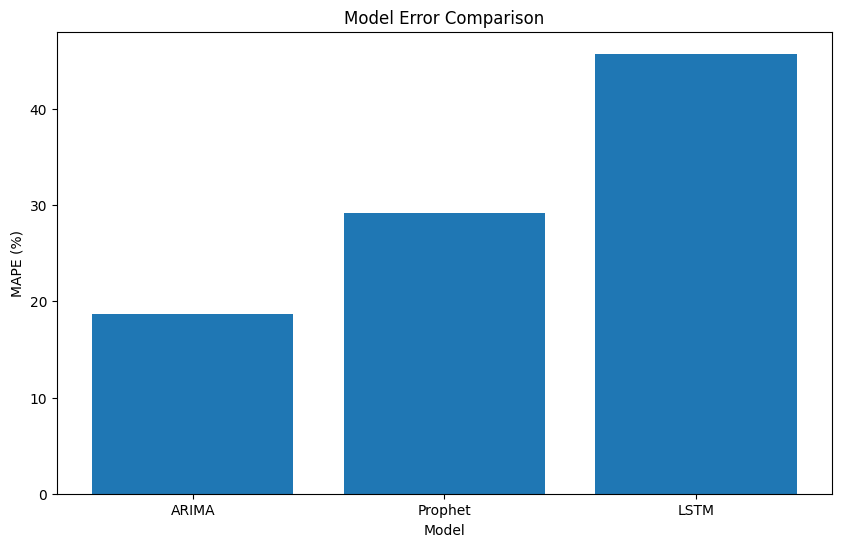

In [33]:
# Calculate error  for each model (replace with your actual calculations)
arima_mape = 18.692908707076228
prophet_mape = 29.222209297973013
lstm_mape = 45.740536397351576
# Create a dictionary to store the model names and their accuracy
model_accuracy = {
    'ARIMA': arima_mape,
    'Prophet': prophet_mape,
    'LSTM': lstm_mape
}

# Create a bar plot to visualize the accuracy
plt.figure(figsize=(10, 6))
plt.bar(model_accuracy.keys(), model_accuracy.values())
plt.xlabel('Model')
plt.ylabel('MAPE (%)')
plt.title('Model Error Comparison')
plt.show()

**7.Save Trained Models**

In [34]:
with open('arima_model.pkl', 'wb') as arima_file:
    pickle.dump(arima_fit, arima_file)



with open('prophet_model.pkl', 'wb') as prophet_file:
    pickle.dump(prophet_model, prophet_file)

with open('lstm_model.pkl', 'wb') as lstm_file:
    pickle.dump(lstm_model, lstm_file)
